In [ ]:
!pip install mip

In [ ]:
from mip import Model, xsum, minimize, BINARY
import math
import matplotlib.pyplot as plt

In [ ]:
# Parámetros del problema
n_clients = 5  # número de clientes
n_vehicles = 3  # reducido el número de vehículos
vehicle_capacity = 40  # aumentada la capacidad

# Coordenadas
locations = [(0, 0), (10, 10), (15, 15), (5, 15), (20, 10), (15, 5)]

# Demandas más pequeñas
demands = [0, 3, 4, 2, 3, 3]

# Distancias
distances = [[math.dist(locations[i], locations[j]) for j in range(n_clients + 1)] for i in range(n_clients + 1)]


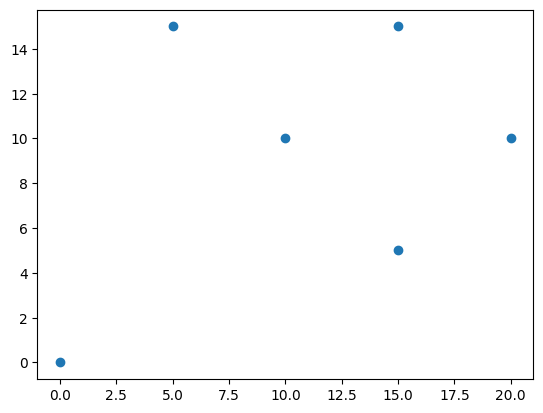

In [ ]:
x = [ li[0] for li in locations ]
y = [ li[1] for li in locations ]

plt.scatter(x, y)
plt.show()

In [ ]:
# Modelo
model = Model()

# Variables
x = [[[model.add_var(var_type=BINARY) for j in range(n_clients + 1)] for i in range(n_clients + 1)] for k in range(n_vehicles)]
t = [model.add_var() for i in range(n_clients + 1)]

# Función objetivo
model.objective = minimize(
    xsum(distances[i][j] * x[k][i][j] for k in range(n_vehicles) for i in range(n_clients + 1) for j in range(n_clients + 1))
)

In [ ]:
# Restricciones básicas
# Cada cliente debe ser visitado una vez
for i in range(1, n_clients + 1):
    model += xsum(x[k][i][j] for k in range(n_vehicles) for j in range(n_clients + 1) if i != j) == 1

# Cada vehículo debe salir del depósito
for k in range(n_vehicles):
    model += xsum(x[k][0][j] for j in range(1, n_clients + 1)) == 1
    model += xsum(x[k][i][0] for i in range(1, n_clients + 1)) == 1

# Conservación de flujo
for k in range(n_vehicles):
    for h in range(n_clients + 1):
        model += xsum(x[k][i][h] for i in range(n_clients + 1) if i != h) == \
                 xsum(x[k][h][j] for j in range(n_clients + 1) if j != h)

# Capacidad del vehículo
for k in range(n_vehicles):
    model += xsum(demands[i] * xsum(x[k][i][j] for j in range(n_clients + 1) if i != j)
                 for i in range(1, n_clients + 1)) <= vehicle_capacity

# Tiempo entre nodos
M = 50
for k in range(n_vehicles):
    for i in range(n_clients + 1):
        for j in range(1, n_clients + 1):
            if i != j:
                model += t[j] >= t[i] + distances[i][j] - M * (1 - x[k][i][j])

In [ ]:
# Optimización
model.optimize(max_seconds=300)

# Mostrar resultados
if model.num_solutions:
    for k in range(n_vehicles):
        route = []
        times = []
        current = 0
        route_load = 0

        while True:
            route.append(current)
            times.append(t[current].x if current != 0 else 0)
            next_node = -1

            for j in range(n_clients + 1):
                if current != j and x[k][current][j].x >= 0.99:
                    next_node = j
                    if j != 0:
                        route_load += demands[j]
                    break

            if next_node == -1 or next_node == 0:
                if next_node == 0:
                    route.append(0)
                    times.append(0)  # tiempo de regreso al depósito
                break
            current = next_node

        if len(route) > 2:
            print(f"\nVehículo {k + 1}:")
            print(f"Ruta: {' -> '.join(map(str, route))}")
            print(f"Carga: {route_load}")
            print(f"Tiempos de llegada: {[round(t, 2) for t in times]}")
            route_length = sum(distances[route[i]][route[i+1]] for i in range(len(route)-1))
            print(f"Longitud de ruta: {route_length:.2f}")
else:
    print("No se encontró solución")


Vehículo 1:
Ruta: 0 -> 3 -> 0
Carga: 2
Tiempos de llegada: [0, 15.81, 0]
Longitud de ruta: 31.62

Vehículo 2:
Ruta: 0 -> 1 -> 0
Carga: 3
Tiempos de llegada: [0, 14.14, 0]
Longitud de ruta: 28.28

Vehículo 3:
Ruta: 0 -> 5 -> 4 -> 2 -> 0
Carga: 10
Tiempos de llegada: [0, 15.81, 22.88, 55.81, 0]
Longitud de ruta: 51.17
